## TXx and TXm trends from Vautard (2023)

#### Notes
- When I weight th gwd it doesn't matter where the weights get added, I tried it after averaging over longitude and I got the same result
- for the West Europe Daily Maximum Temperatures, I think that the time series that I have is the closest, there are slight differences but it's the closest I've gotted
    - Need to 1st take the mean over longitude, multiply by the weights and then take the mean over latitude
    - I think that the Vautard paper cuts off the TS before 1950, so I think that I my start value is fine.
- Spatial Trends are also good, I didn't weight them, might go back and change that later but I get closest without latitude weighting.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy as ccrs

import scipy.stats as stats
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [2]:
#import data
global_months = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_monthly_temperature_1940-2024_global.nc")
era_max = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max.nc")
era_max_regrid = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/era5_t2m_1950-2022_daily_max_regrid.nc")
lsm = xr.open_dataset("/scratch/rwhite/jrobs12/analogue_data/europe_mask_0.5.nc")
small_mask = (lsm.sel(longitude = slice(-5,15), latitude = slice(55,45)).t2m)/(lsm.sel(longitude = slice(-5,15), latitude = slice(55,45)).t2m)

In [3]:
#find gwd
#weighting by latitude
weights = np.cos(np.deg2rad(global_months.latitude))
weighted_weights = weights/np.mean(weights)

weighted_temps = global_months.sel(expver = 1).groupby("latitude")*weighted_weights
weighted_global_mean = weighted_temps.t2m.sel(time = slice('1950', '2022')).mean(dim = ['latitude', 'longitude'])
weighted_yearly_mean = weighted_global_mean.groupby("time.year").mean()
weighted_rolling_mean = weighted_yearly_mean.rolling(year = 5, center=True, min_periods = 3).mean()
weighted_gwd_2022 = weighted_rolling_mean[-1]
weighted_gwd = weighted_rolling_mean - weighted_gwd_2022
weighted_gwd

<xarray.DataArray 't2m' (year: 73)>
array([-1.0198059 , -0.99212646, -1.0148926 , -1.019104  , -1.061676  ,
       -1.0514526 , -1.0432739 , -1.0027466 , -0.9676819 , -0.9055786 ,
       -0.9052429 , -0.91085815, -0.95184326, -0.971405  , -0.9904785 ,
       -0.9948425 , -1.0190125 , -0.97457886, -0.9476013 , -0.9671936 ,
       -0.9623718 , -0.92440796, -0.967865  , -1.0013123 , -1.0174866 ,
       -1.0035706 , -1.0221252 , -0.95440674, -0.86538696, -0.7559509 ,
       -0.7435913 , -0.68045044, -0.69091797, -0.7357483 , -0.76950073,
       -0.7322693 , -0.7276306 , -0.70410156, -0.6262207 , -0.5770569 ,
       -0.6053772 , -0.6309509 , -0.62561035, -0.63098145, -0.6514282 ,
       -0.60098267, -0.5220032 , -0.50405884, -0.52267456, -0.48324585,
       -0.4489746 , -0.4550171 , -0.41952515, -0.35061646, -0.32333374,
       -0.3168335 , -0.33422852, -0.31323242, -0.3055725 , -0.3166504 ,
       -0.31600952, -0.28344727, -0.26919556, -0.24420166, -0.15411377,
       -0.09335327, -0.05395508,  0.00463867,  0.03994751,  0.00683594,
       -0.00170898,  0.01583862,  0.        ], dtype=float32)
Coordinates:
    expver   int32 1
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2018 2019 2020 2021 2022

In [5]:
#weight era_max by latitude
lats = era_max.sel(latitude = slice(55,45)).latitude
max_weights = np.cos(np.deg2rad(lats))
weighted_max_weights = max_weights/np.mean(max_weights)

#find timeseries data
era_max_temp = era_max.sel(latitude = slice(55,45), longitude = slice(-5,15)).groupby("time.year").max()*small_mask
era_ts = era_max_temp.mean(dim = ["longitude"]).t2m*weighted_max_weights
TXx_ts = era_ts.mean(dim = "latitude").T
time = TXx_ts.year

TXx_trend_gwd = stats.linregress(weighted_gwd, TXx_ts - 273.15)
TXx_trend_time = stats.linregress(time, TXx_ts - 273.15)

TXx_trend_gwd

LinregressResult(slope=3.3781947549508247, intercept=32.16314307179899, rvalue=0.6654602328106235, pvalue=1.339139386509859e-10, stderr=0.4497015765535678, intercept_stderr=0.3264022496186202)

Text(0.5, 1.0, 'Summer Maximal Temperatures over Western Europe Land \n [5W-15E, 45N-55N] on 0.5x0.5 grid')

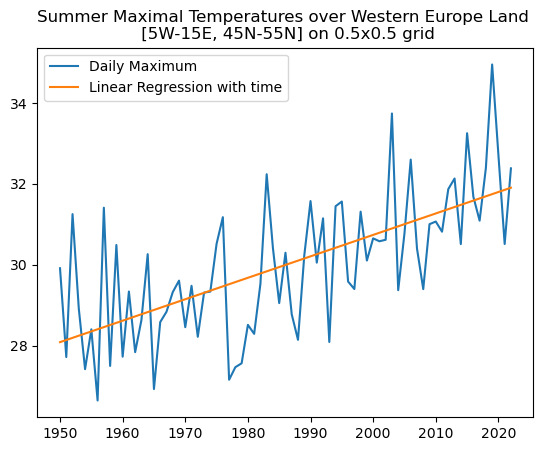

In [6]:
f, axs = plt.subplots(1,1)
plt.plot(time,(TXx_ts.T - 273.15).values, label = "Daily Maximum")
#((west_europe_TXx-273.15)).plot(label = "Daily Maximum")
trend_line = time*(TXx_trend_time.slope) + TXx_trend_time.intercept
plt.plot(time, trend_line, label = "Linear Regression with time")
#((west_europe_TXm-273.15)).plot(label = "Daily Mean")
plt.legend()
plt.title("Summer Maximal Temperatures over Western Europe Land \n [5W-15E, 45N-55N] on 0.5x0.5 grid")
#(gwd).plot(label = "Global Average")

In [14]:
#Find TXx and TXm for maps
map_lats = era_max.latitude
map_weights = np.cos(np.deg2rad(map_lats))
weighted_map_weights = map_weights/np.mean(map_weights)
TXx = era_max.groupby("time.year").max()#*weighted_map_weights
TXm = era_max.groupby("time.year").mean()#*weighted_map_weights

In [15]:
#calculate TXx trend
lons,lats = np.linspace(1,len(TXx.longitude),len(TXx.longitude)), np.linspace(1,len(TXx.latitude),len(TXx.latitude))
max_trend_map = (np.meshgrid(lons,lats)[1]).T
for ii, lon in enumerate(TXx.longitude):
    for jj, lat in enumerate(TXx.latitude):
        temps = TXx.sel(longitude = lon, latitude = lat).t2m
        regression = stats.linregress(weighted_gwd, temps)
        trend = regression.slope
        max_trend_map[ii,jj] = trend

In [16]:
#Calculate TXm trend
mean_trend_map = (np.meshgrid(lons,lats)[1]).T
for ii, lon in enumerate(TXm.longitude):
    for jj, lat in enumerate(TXm.latitude):
        temps = TXm.sel(longitude = lon, latitude = lat).t2m
        regression = stats.linregress(weighted_gwd, temps)
        trend = regression.slope
        mean_trend_map[ii,jj] = trend

In [30]:
#plotting stuff
cmap = matplotlib.cm.hot_r
bounds = [0, 1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
norm = matplotlib.colors.BoundaryNorm(bounds,cmap.N, extend='both')

Text(0.5, 1.0, 'TXx Trend (1950-2022)')

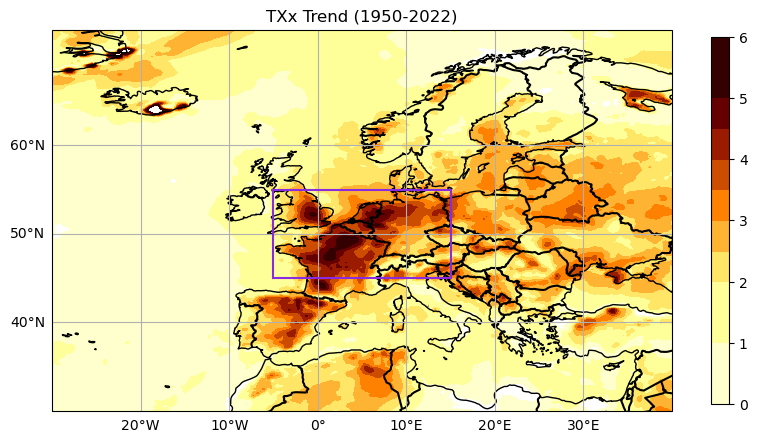

In [31]:
transform = ccrs.Orthographic(central_longitude = 5, central_latitude = 50)
fig = plt.figure(figsize = (10,15))
latgrids=[40,50,60]
longrids=[-20,-10,0,10,20,30]

ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(TXx.longitude, TXx.latitude, max_trend_map.T,
                                    cmap = 'afmhot_r', levels = np.linspace(0,6,13), 
                                 transform = ccrs.PlateCarree(), norm = norm)
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 70])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("TXx Trend (1950-2022)")

Text(0.5, 1.0, 'TXm trend (1950-2022)')

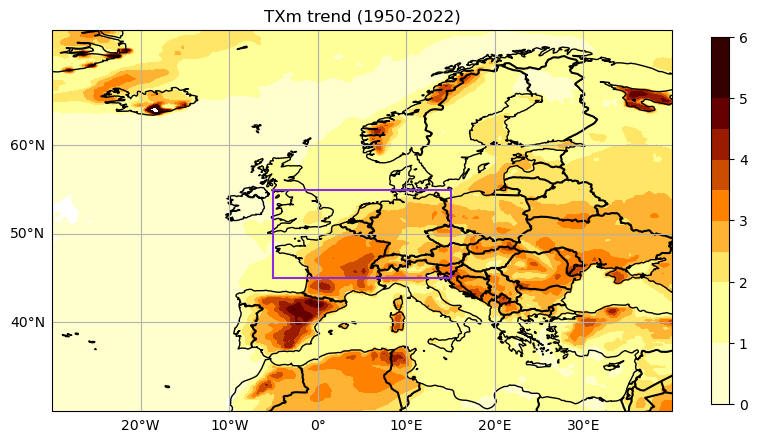

In [32]:
fig = plt.figure(figsize = (10,15))
ax = plt.subplot(2,1,1,projection = ccrs.PlateCarree())
j = plt.contourf(TXm.longitude, TXm.latitude, mean_trend_map.T,
                                    cmap = 'afmhot_r', levels = np.linspace(0,6,13), 
                                 transform = ccrs.PlateCarree(), norm = norm)
plt.colorbar(j, shrink = 0.7)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.set_extent([-30, 40, 30, 70])
#plotting box
bv = "blueviolet"
plt.plot([-5,-5], [45,55], color = bv)
plt.plot([15,15], [45,55], color = bv)
plt.plot([-5,15], [45,45], color = bv)
plt.plot([-5,15], [55,55], color = bv)
gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
gl.top_labels = None
gl.right_labels = None
ax.set_title("TXm trend (1950-2022)")